In [0]:
import os
import zipfile
local_zip = '/content/drive/My Drive/Dataset/IMG_classification.zip'

In [0]:
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/IMG_classification'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training cat/dog pictures
train_dhar_dir = os.path.join(train_dir, 'Dharmesh')
train_hars_dir = os.path.join(train_dir, 'Harshal')

# Directory with our validation cat/dog pictures
validation_dhar_dir = os.path.join(validation_dir, 'Dharmesh_val')
validation_hars_dir = os.path.join(validation_dir, 'Harshal_val')

In [0]:
train_dhar_fnames = os.listdir( train_dhar_dir )
train_hars_fnames = os.listdir( train_hars_dir )

print(train_dhar_fnames[:5])
print(train_hars_fnames[:5])

['IMG-20200202-WA0016.jpg', 'IMG-20200202-WA0001.jpg', 'IMG-20200202-WA0020.jpg', 'IMG-20200202-WA0005.jpg', 'IMG-20200202-WA0010.jpg']
['IMG-20200202-WA0027.jpg', 'IMG-20200202-WA0023.jpg', 'IMG-20200202-WA0051.jpg', 'IMG-20200202-WA0045.jpg', 'IMG-20200202-WA0042.jpg']


In [0]:
print('total training dharmesh images :', len(os.listdir(      train_dhar_dir ) ))
print('total training harshal images :', len(os.listdir(      train_hars_dir ) ))

print('total validation dharmesh images :', len(os.listdir( validation_dhar_dir ) ))
print('total validation harshal images :', len(os.listdir( validation_hars_dir ) ))

total training dharmesh images : 22
total training harshal images : 30
total validation dharmesh images : 4
total validation harshal images : 5


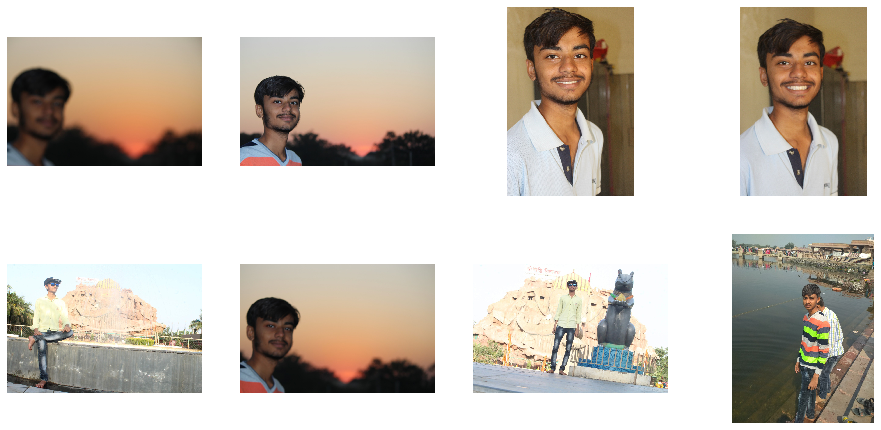

In [0]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_dhar_dir, fname) 
                for fname in train_dhar_fnames[ pic_index-9:pic_index-1] 
               ]

next_dog_pix = [os.path.join(train_hars_dir, fname) 
                for fname in train_hars_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [0]:
import tensorflow as tf

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(150,150,3),
                                               include_top=False,
                                               weights='imagenet')


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
base_model.trainable = False

base_model.summary()

last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 52 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( base_model.input, x) 

model.compile(optimizer = Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
initial_epochs = 4

In [0]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 4,
            validation_steps = 50,
            verbose = 2)

Epoch 1/4
Epoch 1/4
100/100 - 50s - loss: 1.1657 - acc: 0.9334 - val_loss: 0.7816 - val_acc: 0.6667
Epoch 2/4
Epoch 1/4
100/100 - 46s - loss: 0.0278 - acc: 0.9908 - val_loss: 2.2452e-04 - val_acc: 1.0000
Epoch 3/4
Epoch 1/4
100/100 - 47s - loss: 0.0298 - acc: 0.9931 - val_loss: 1.4761 - val_acc: 0.6667
Epoch 4/4
Epoch 1/4
100/100 - 46s - loss: 0.0611 - acc: 0.9884 - val_loss: 0.0871 - val_acc: 0.8889


In [0]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(optimizer = Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
len(model.trainable_variables)
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 1,
            validation_steps = 50,
            verbose = 2)


100/100 - 47s - loss: 0.3784 - acc: 0.9384 - val_loss: 753.4629 - val_acc: 0.5556


In [0]:
#save model to drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()            
drive = GoogleDrive(gauth)

In [0]:
model.save('model_mobile.h5')
model_file = drive.CreateFile({'title' : 'model_mobile.h5'})                       
model_file.SetContentFile('model_mobile.h5')
model_file.Upload()

In [0]:
new_model = tf.keras.models.load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  print(images.shape)
  classes = model.predict(images, batch_size=10)
  
  print(classes)
  
  if classes[0]>0.5:
    print(fn + " is a harshal") 
  else:
    print(fn + " is a harshal")

Saving IMG-20200202-WA0031.jpg to IMG-20200202-WA0031.jpg
(1, 150, 150, 3)
[[1.]]
IMG-20200202-WA0031.jpg is a harshal
